# Практическая работа 3

## Регрессионный анализ

Выполнил: Самарин Никита Группа: КИ21-17/2Б

Цель: знакомство с теоретическими основами регрессионного анализа,
формирование навыков применения регрессионного анализа для решения
задачи восстановления функциональных зависимостей с помощью языка
программирования Python.

Задачи:
Выполнение практической работы предполагает решение следующий
задач:
1. Предварительная обработку исходных данных
2. Обучение базовых регрессионных моделей
3. Подбор оптимальных параметров регрессионных моделей
4. Оценка качества построенных моделей на валидационной/тестовой
выборке

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
import warnings


import utilities2

warnings.filterwarnings('ignore')

In [101]:
cat_attributes = ['Мусоропровод', 'Аварийный', 'Железобетонные.перекрытия', 'Смешанные.перекрытия', 'Деревянные.перекрытия', 'Иные.перекрытия', 'Панельные.стены', 'Блочные.стены', 'Деревянные.стены', 'Кирпичные.стены', 'Монолитные.стены', 'Смешанные.стены', 'Косметический', 'Евроремонт', 'Дизайнерский', 'Без.ремонта', 'Парковка', 'Студия']
num_attributes = ['Количество.комнат', 'Общая.площадь', 'Этаж', 'Этажей.в.доме', 'Год.постройки', 'Школа.1000', 'ВУЗ.1000', 'ТЦ.1000', 'Стоматология.1000', 'Почта.1000', 'Поликлиника.1000', 'Парк.1000', 'Остановка.1000', 'Одежда..1000', 'Супер3кет.1000', 'Кинотеатр.1000', 'Кафе.1000', 'АЗС.1000', 'Детский.сад.1000', 'Бар.1000', 'Банк.1000', 'Аптека.1000', 'Балкон', 'Лоджия', 'Совмещенный.санузел', 'Раздельный.санузел', 'Лифт', 'Грузовой.лифт']
r_class = 'Цена'
dataframe = pd.read_csv("train.csv", usecols = cat_attributes + num_attributes + [r_class])
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Количество.комнат          808 non-null    int64  
 1   Студия                     808 non-null    int64  
 2   Общая.площадь              808 non-null    float64
 3   Этаж                       808 non-null    int64  
 4   Этажей.в.доме              808 non-null    int64  
 5   Парковка                   808 non-null    int64  
 6   Без.ремонта                808 non-null    int64  
 7   Дизайнерский               808 non-null    int64  
 8   Евроремонт                 808 non-null    int64  
 9   Косметический              808 non-null    int64  
 10  Балкон                     808 non-null    int64  
 11  Лоджия                     808 non-null    int64  
 12  Совмещенный.санузел        808 non-null    int64  
 13  Раздельный.санузел         808 non-null    int64  

In [102]:
dataframe[num_attributes + [r_class]] = dataframe[num_attributes + [r_class]].apply(pd.to_numeric, errors="coerce")

In [103]:
print(dataframe.isnull().sum())

Количество.комнат            0
Студия                       0
Общая.площадь                0
Этаж                         0
Этажей.в.доме                0
Парковка                     0
Без.ремонта                  0
Дизайнерский                 0
Евроремонт                   0
Косметический                0
Балкон                       0
Лоджия                       0
Совмещенный.санузел          0
Раздельный.санузел           0
Лифт                         0
Грузовой.лифт                0
Мусоропровод                 0
Год.постройки                0
Аварийный                    0
Железобетонные.перекрытия    0
Смешанные.перекрытия         0
Деревянные.перекрытия        0
Иные.перекрытия              0
Панельные.стены              0
Блочные.стены                0
Деревянные.стены             0
Кирпичные.стены              0
Монолитные.стены             0
Смешанные.стены              0
Школа.1000                   0
ВУЗ.1000                     0
ТЦ.1000                      0
Стоматол

In [104]:
#scaler = MinMaxScaler()
#for i in num_attributes:
#    numeric_dataframe = dataframe[[i]]
#    numeric_dataframe = scaler.fit_transform(numeric_dataframe)
#    dataframe[i + "_norm"] = numeric_dataframe
#dataframe.drop(num_attributes, axis = 'columns', inplace = True)
#dataframe.columns = dataframe.columns.str.replace('_norm', '')
#dataframe = dataframe[cat_attributes + num_attributes + [r_class]]
#dataframe.head()

## Исследуем данные на коллинеарность

<Axes: >

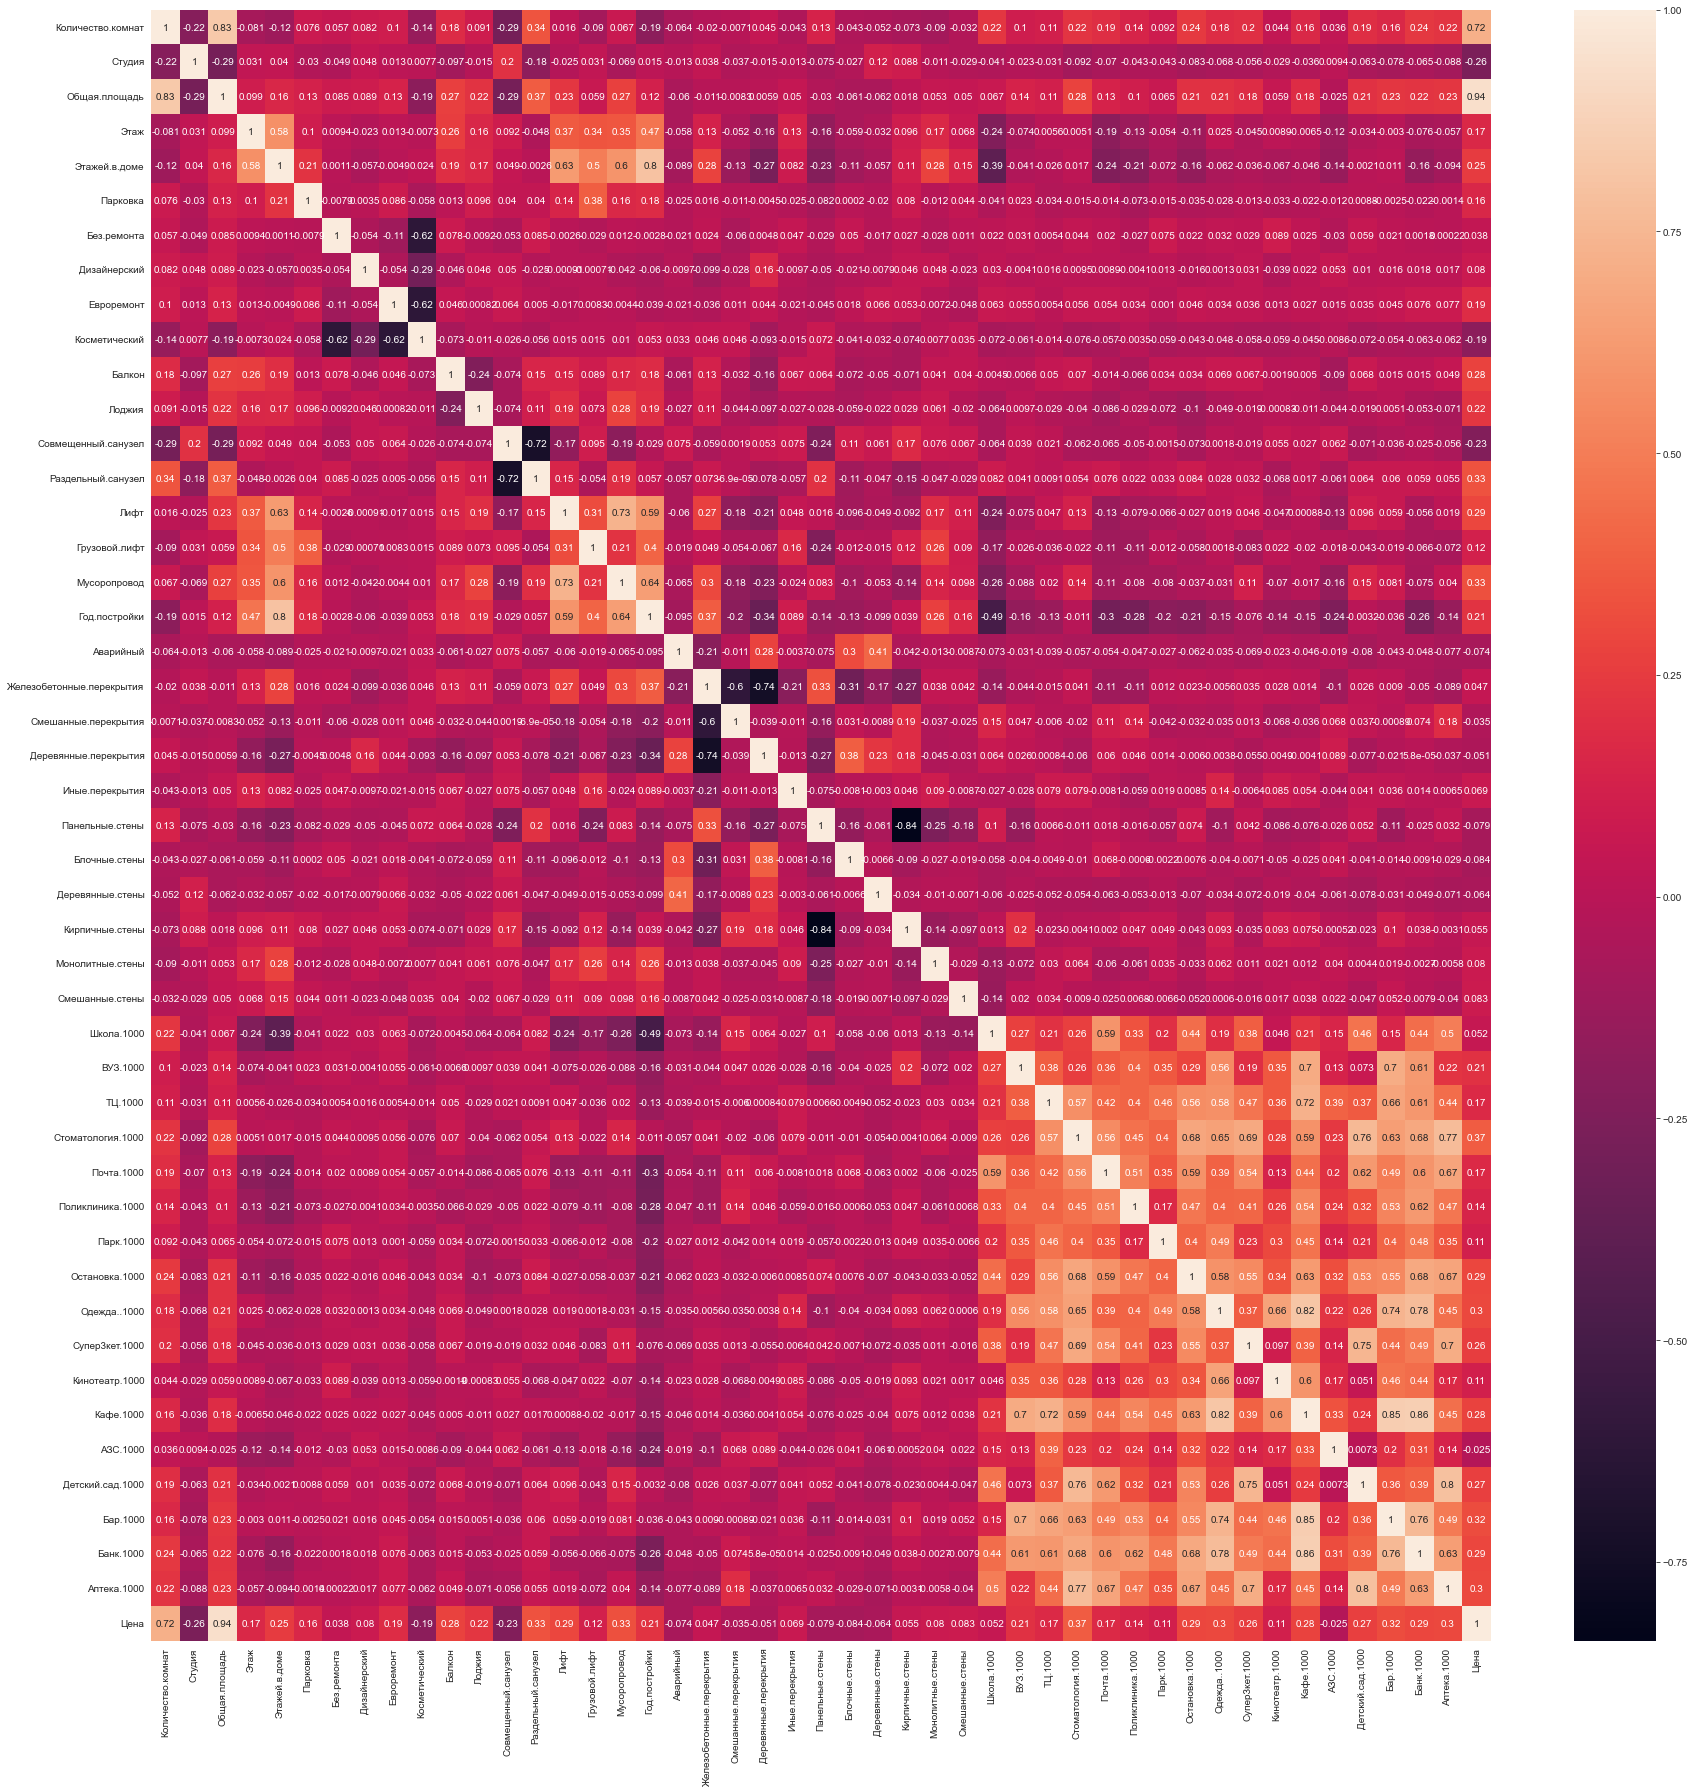

In [105]:
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(dataframe.corr(), annot=True)

In [106]:
corr_matrix = dataframe.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_1 = []
for column in upper.columns:
    if column not in to_drop_1:
        for row in upper.columns:
            if row not in to_drop_1:
                corr = upper[column][row]
                if corr is not None:
                    if corr > 0.8:
                        if upper["Цена"][column] > upper["Цена"][row]:
                            to_drop_1.append(row)
                        else:
                            to_drop_1.append(column)
                            break
if r_class in to_drop_1: to_drop_1.remove(r_class)
to_drop_2 = [column for column in upper.columns if (upper["Цена"][column] < 0.2)]
to_drop_2 = [x for x in to_drop_2 if x not in to_drop_1]
dataframe.drop(to_drop_1, axis=1, inplace=True)
dataframe.drop(to_drop_2, axis=1, inplace=True)
cat_attributes = [x for x in cat_attributes if x not in (to_drop_1 + to_drop_2)]
num_attributes = [x for x in num_attributes if x not in (to_drop_1 + to_drop_2)]
dataframe_x = dataframe[cat_attributes + num_attributes]
dataframe_y = dataframe[r_class]

<Axes: >

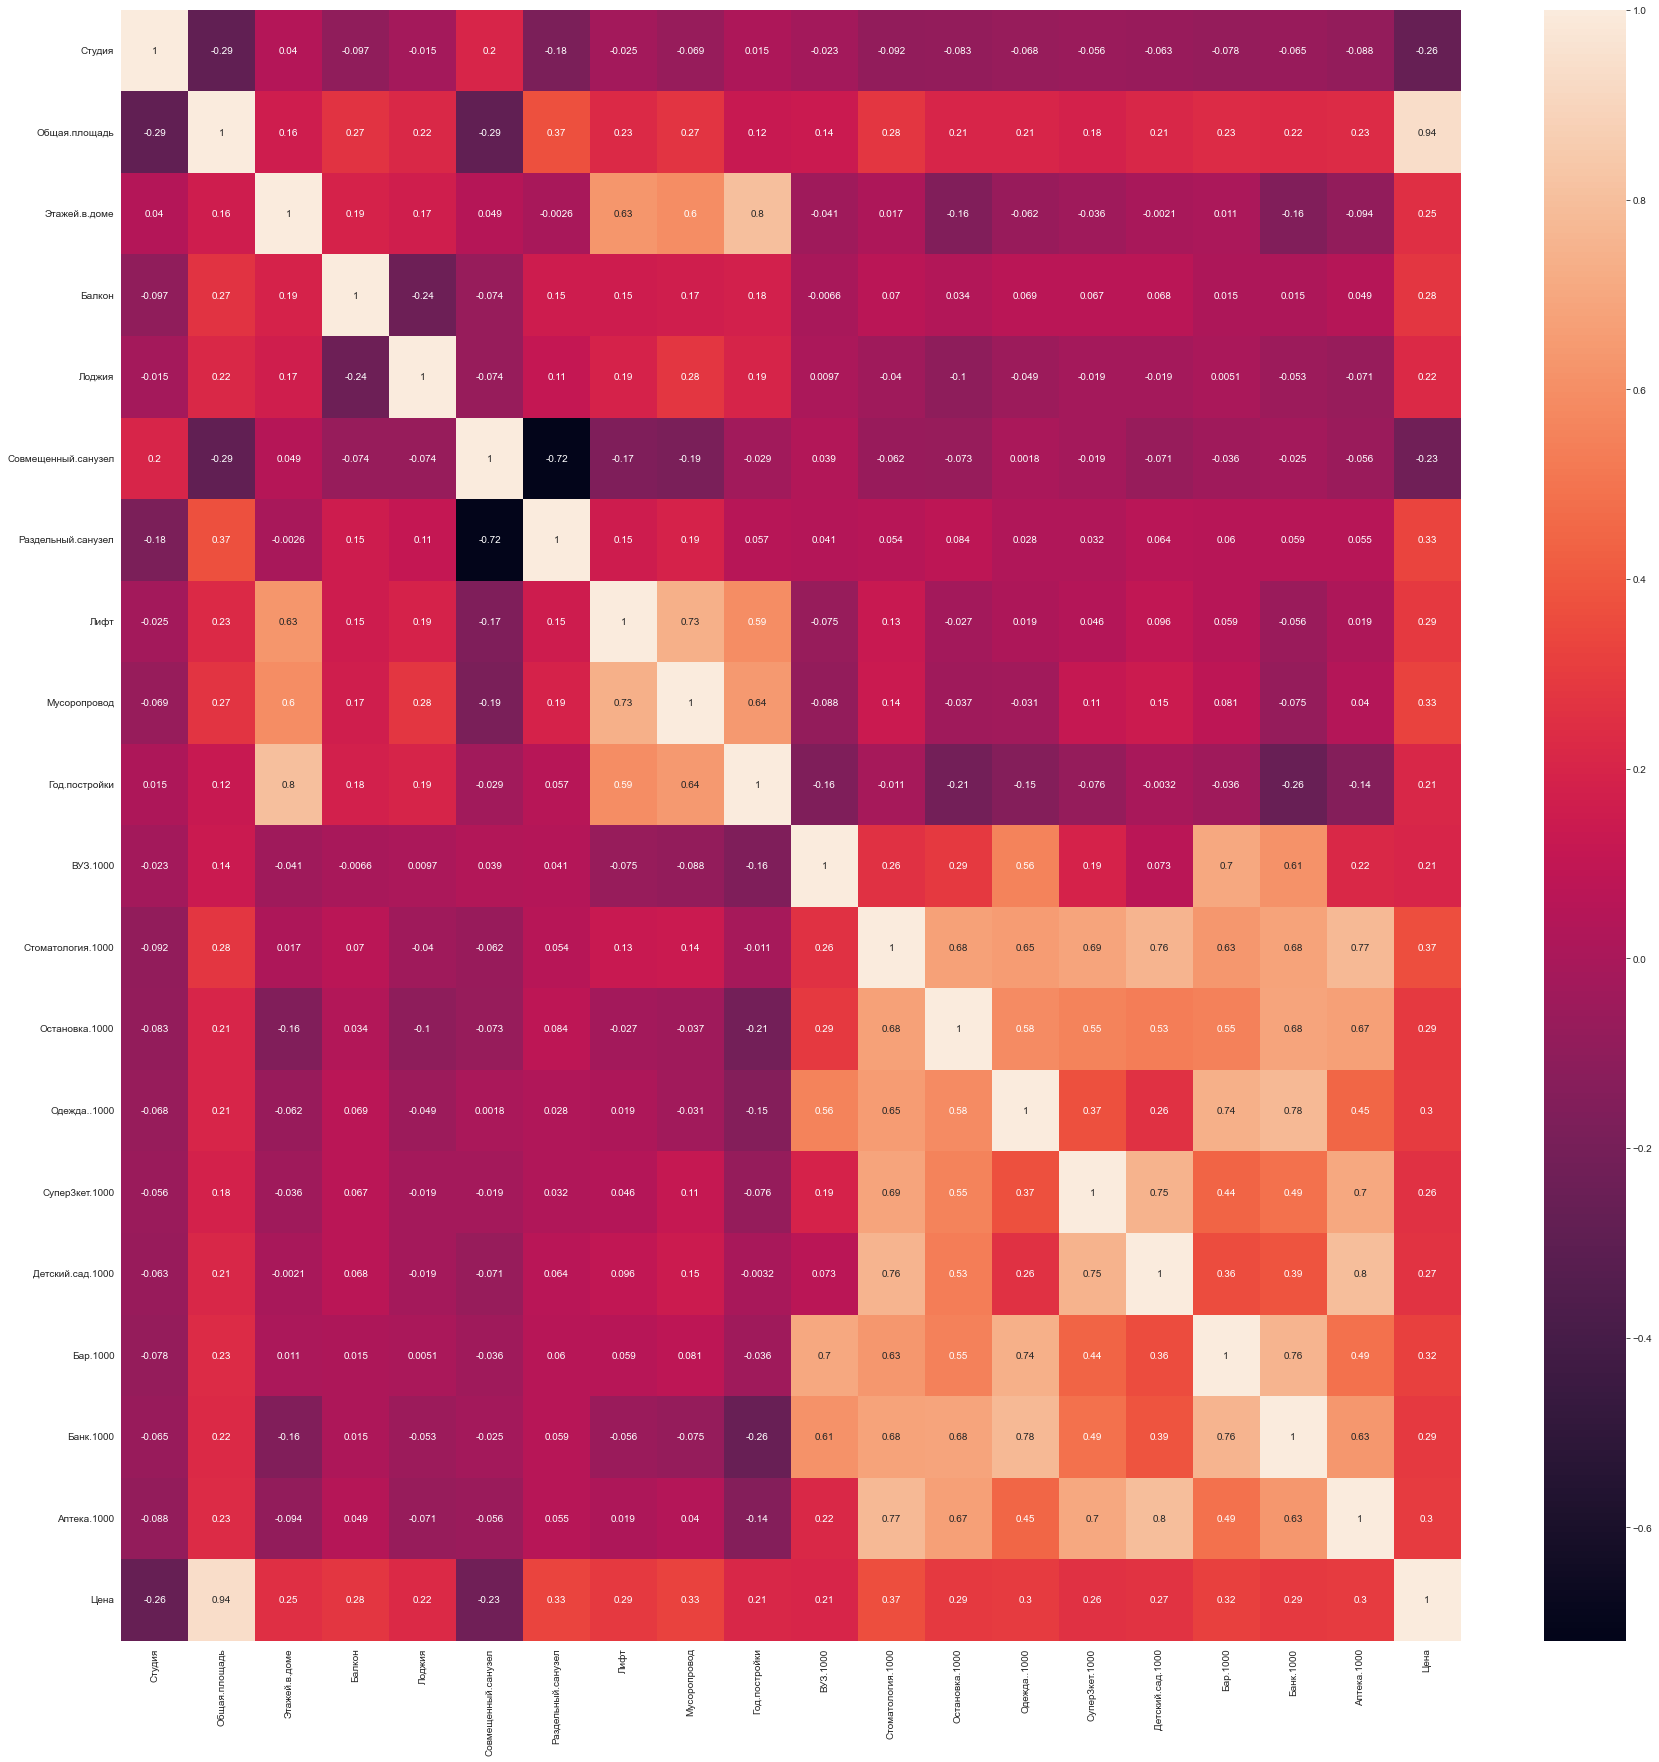

In [107]:
fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(dataframe.corr(), annot=True)

## Отбор признаков

In [108]:
selector = SequentialFeatureSelector(linear_model.LinearRegression(), n_features_to_select='auto')
selector.fit(dataframe_x, dataframe_y)
cols = dataframe_x.columns[selector.get_support()].tolist()
print(cols)
cat_attributes = [x for x in cat_attributes if x in cols]
num_attributes = [x for x in num_attributes if x in cols]
dataframe_x = dataframe[cat_attributes + num_attributes]
dataframe_y = dataframe[r_class]

['Общая.площадь', 'Этажей.в.доме', 'Год.постройки', 'ВУЗ.1000', 'Стоматология.1000', 'Остановка.1000', 'Одежда..1000', 'Бар.1000', 'Совмещенный.санузел']


## Построим регрессионные модели

In [109]:
x_train, x_test, y_train, y_test = train_test_split(dataframe_x, dataframe_y, test_size=0.3, random_state=0)
labels = []
RMSEs = []
r2_scores = []
models = []

1. Линейная регрессия (МНК)

In [110]:
model = linear_model.LinearRegression()
parameters = {'fit_intercept': [True, False]}
cv = utilities2.grid_search(model, parameters, x_train, x_test, y_train, y_test)
linear_regression = cv

rmse, r2 = utilities2.get_stats(linear_regression, x_test, y_test)
utilities2.param_stats(linear_regression.best_estimator_, x_test, y_test)

labels.append("linear_regression")
RMSEs.append(rmse)
r2_scores.append(r2)
models.append(linear_regression)

Tuned hpyerparameters (best parameters): {'fit_intercept': True}
RMSE of model: 339854.6000
R2 of model: 0.8883
Adj R2 of model: 0.8840
AIC of model: 6207.8288
BIC of model: 6239.2663
                 param  Coefficients  Standard Errors  t values  P> |t|  \
1        Общая.площадь    47111.5528         1197.719    39.334   0.000   
2        Этажей.в.доме     2763.9395         8599.365     0.321   0.748   
3        Год.постройки     7149.9988         1898.957     3.765   0.000   
4             ВУЗ.1000     9789.8905         5766.699     1.698   0.091   
5    Стоматология.1000     7056.9264         5384.595     1.311   0.191   
6       Остановка.1000    11206.6116         6021.548     1.861   0.064   
7         Одежда..1000     5085.0907         2415.298     2.105   0.036   
8             Бар.1000    -8176.7180         8299.034    -0.985   0.326   
9  Совмещенный.санузел    58286.3817        47178.171     1.235   0.218   

    interval_a   interval_b  
1    47.966374    52.857083  
2    

2. Лассо регрессия

In [111]:
model = linear_model.LassoCV(cv=5, random_state=0)
model.fit(x_train, y_train)

lasso = model
rmse, r2 = utilities2.get_stats(lasso, x_test, y_test)
utilities2.param_stats(lasso, x_test, y_test)

labels.append("lasso")
RMSEs.append(rmse)
r2_scores.append(r2)
models.append(lasso)

RMSE of model: 339495.2000
R2 of model: 0.8885
Adj R2 of model: 0.8843
AIC of model: 6207.3145
BIC of model: 6238.7521
                 param  Coefficients  Standard Errors  t values  P> |t|  \
1        Общая.площадь    46751.1000         1208.626    38.681   0.000   
2        Этажей.в.доме        0.0000         8677.676     0.000   1.000   
3        Год.постройки     7141.5131         1916.250     3.727   0.000   
4             ВУЗ.1000     3829.7213         5819.214     0.658   0.511   
5    Стоматология.1000     4231.7931         5433.631     0.779   0.437   
6       Остановка.1000     6451.6889         6076.383     1.062   0.289   
7         Одежда..1000     5891.9783         2437.293     2.417   0.016   
8             Бар.1000       -0.0000         8374.609    -0.000   1.000   
9  Совмещенный.санузел        0.0000        47607.801     0.000   1.000   

    interval_a   interval_b  
1    47.966374    52.857083  
2     8.223742     9.340044  
3  1983.593465  1988.653448  
4     2.14

3. Гребневая регрессия

In [112]:
model = linear_model.RidgeCV(cv=5)
model.fit(x_train, y_train)
ridge = model

rmse, r2 = utilities2.get_stats(ridge, x_test, y_test)
utilities2.param_stats(ridge, x_test, y_test)

labels.append("Ridge")
RMSEs.append(rmse)
r2_scores.append(r2)
models.append(ridge)

RMSE of model: 339854.1000
R2 of model: 0.8883
Adj R2 of model: 0.8840
AIC of model: 6207.8280
BIC of model: 6239.2656
                 param  Coefficients  Standard Errors  t values  P> |t|  \
1        Общая.площадь    47042.9737         1197.830    39.273   0.000   
2        Этажей.в.доме     3191.2672         8600.163     0.371   0.711   
3        Год.постройки     7072.8311         1899.134     3.724   0.000   
4             ВУЗ.1000     9684.2217         5767.234     1.679   0.094   
5    Стоматология.1000     7064.5653         5385.095     1.312   0.191   
6       Остановка.1000    11029.6332         6022.107     1.832   0.068   
7         Одежда..1000     5173.7081         2415.522     2.142   0.033   
8             Бар.1000    -8164.9258         8299.804    -0.984   0.326   
9  Совмещенный.санузел    48494.6325        47182.549     1.028   0.305   

    interval_a   interval_b  
1    47.966374    52.857083  
2     8.223742     9.340044  
3  1983.593465  1988.653448  
4     2.14

4. Elastic-Net

In [113]:
model = linear_model.ElasticNet()
parameters = {'alpha':list(np.logspace(0, 20, 40))}
cv = utilities2.grid_search(model, parameters, x_train, x_test, y_train, y_test)
elastic_net = cv

rmse, r2 = utilities2.get_stats(elastic_net, x_test, y_test)
utilities2.param_stats(elastic_net.best_estimator_, x_test, y_test)

labels.append("elastic_net")
RMSEs.append(rmse)
r2_scores.append(r2)
models.append(elastic_net)

Tuned hpyerparameters (best parameters): {'alpha': 1.0}
RMSE of model: 339651.8000
R2 of model: 0.8884
Adj R2 of model: 0.8842
AIC of model: 6207.5387
BIC of model: 6238.9762
                 param  Coefficients  Standard Errors  t values  P> |t|  \
1        Общая.площадь    46782.5634         1199.764    38.993   0.000   
2        Этажей.в.доме     4508.4168         8614.052     0.523   0.601   
3        Год.постройки     6812.2586         1902.201     3.581   0.000   
4             ВУЗ.1000     9008.8076         5776.548     1.560   0.120   
5    Стоматология.1000     6926.5373         5393.792     1.284   0.200   
6       Остановка.1000    10248.6695         6031.832     1.699   0.091   
7         Одежда..1000     5465.7176         2419.423     2.259   0.025   
8             Бар.1000    -7497.4039         8313.208    -0.902   0.368   
9  Совмещенный.санузел    16787.3001        47258.748     0.355   0.723   

    interval_a   interval_b  
1    47.966374    52.857083  
2     8.223742

5. Метод наименьших углов (Least-angle regression)

In [114]:
model = linear_model.LarsCV(cv=5)
model.fit(x_train, y_train)
lars = model

rmse, r2 = utilities2.get_stats(lars, x_test, y_test)
utilities2.param_stats(lars, x_test, y_test)

labels.append("lars")
RMSEs.append(rmse)
r2_scores.append(r2)
models.append(lars)

RMSE of model: 339854.6000
R2 of model: 0.8883
Adj R2 of model: 0.8840
AIC of model: 6207.8288
BIC of model: 6239.2663
                 param  Coefficients  Standard Errors  t values  P> |t|  \
1        Общая.площадь    46753.2702         1209.439    38.657   0.000   
2        Этажей.в.доме        0.0000         8683.514     0.000   1.000   
3        Год.постройки     7089.7857         1917.540     3.697   0.000   
4             ВУЗ.1000     3342.6836         5823.129     0.574   0.566   
5    Стоматология.1000     4159.5065         5437.286     0.765   0.445   
6       Остановка.1000     5978.1170         6080.472     0.983   0.327   
7         Одежда..1000     6044.2963         2438.933     2.478   0.014   
8             Бар.1000        0.0000         8380.244     0.000   1.000   
9  Совмещенный.санузел        0.0000        47639.833     0.000   1.000   

    interval_a   interval_b  
1    47.966374    52.857083  
2     8.223742     9.340044  
3  1983.593465  1988.653448  
4     2.14

6. Байесовская регрессия

In [115]:
model = linear_model.BayesianRidge()
parameters = {'fit_intercept': [True, False]}
cv = utilities2.grid_search(model, parameters, x_train, x_test, y_train, y_test)
bayes_ridge = cv

rmse, r2 = utilities2.get_stats(bayes_ridge, x_test, y_test)
utilities2.param_stats(bayes_ridge.best_estimator_, x_test, y_test)

labels.append("bayes_ridge")
RMSEs.append(rmse)
r2_scores.append(r2)
models.append(bayes_ridge)

Tuned hpyerparameters (best parameters): {'fit_intercept': True}
RMSE of model: 339750.3000
R2 of model: 0.8884
Adj R2 of model: 0.8841
AIC of model: 6207.6796
BIC of model: 6239.1171
                 param  Coefficients  Standard Errors  t values  P> |t|  \
1        Общая.площадь    46625.0189         1201.020    38.821   0.000   
2        Этажей.в.доме     4736.7044         8623.070     0.549   0.583   
3        Год.постройки     6721.1932         1904.192     3.530   0.001   
4             ВУЗ.1000     8233.0534         5782.595     1.424   0.156   
5    Стоматология.1000     6627.9111         5399.438     1.228   0.221   
6       Остановка.1000     9623.0284         6038.147     1.594   0.112   
7         Одежда..1000     5564.1644         2421.956     2.297   0.022   
8             Бар.1000    -6229.6304         8321.910    -0.749   0.455   
9  Совмещенный.санузел     7604.1680        47308.220     0.161   0.872   

    interval_a   interval_b  
1    47.966374    52.857083  
2    

7. Обобщенная линейная регрессия (обобщенный МНК)

In [116]:
model = linear_model.TweedieRegressor()
parameters = {'alpha':list(np.logspace(0, 20, 40))}
cv = utilities2.grid_search(model, parameters, x_train, x_test, y_train, y_test)
gen_linear = cv

rmse, r2 = utilities2.get_stats(gen_linear, x_test, y_test)
utilities2.param_stats(gen_linear.best_estimator_, x_test, y_test)

labels.append("gen_linear")
RMSEs.append(rmse)
r2_scores.append(r2)
models.append(gen_linear)

Tuned hpyerparameters (best parameters): {'alpha': 1.0}
RMSE of model: 354679.6000
R2 of model: 0.8783
Adj R2 of model: 0.8737
AIC of model: 6228.5795
BIC of model: 6260.0170
                 param  Coefficients  Standard Errors  t values  P> |t|  \
1        Общая.площадь    46504.2675         1249.697    37.212   0.000   
2        Этажей.в.доме    31970.9336         8972.560     3.563   0.000   
3        Год.постройки    -1404.2839         1981.368    -0.709   0.479   
4             ВУЗ.1000     2017.6481         6016.962     0.335   0.738   
5    Стоматология.1000     7331.9265         5618.276     1.305   0.193   
6       Остановка.1000     5165.7105         6282.870     0.822   0.412   
7         Одежда..1000     6205.2147         2520.117     2.462   0.015   
8             Бар.1000    -3654.5196         8659.194    -0.422   0.673   
9  Совмещенный.санузел     1576.4630        49225.605     0.032   0.974   

    interval_a   interval_b  
1    47.966374    52.857083  
2     8.223742

8. Взвешенный МНК

In [117]:
wls_model = sm.WLS(y_train, x_train)
wls = wls_model.fit()
rmse, r2 = utilities2.get_stats(wls, x_test, y_test)
print(wls.summary())
labels.append("wls")
RMSEs.append(rmse)
r2_scores.append(r2)
models.append(wls)

RMSE of model: 351069.1000
R2 of model: 0.8808
Adj R2 of model: 0.8763
AIC of model: 6223.6068
BIC of model: 6255.0444
                                 WLS Regression Results                                
Dep. Variable:                   Цена   R-squared (uncentered):                   0.989
Model:                            WLS   Adj. R-squared (uncentered):              0.988
Method:                 Least Squares   F-statistic:                              5359.
Date:                Thu, 20 Apr 2023   Prob (F-statistic):                        0.00
Time:                        13:08:21   Log-Likelihood:                         -7953.5
No. Observations:                 565   AIC:                                  1.592e+04
Df Residuals:                     556   BIC:                                  1.596e+04
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
 

9. Полиномиальная регрессия

In [118]:
poly_feat = PolynomialFeatures()
x_poly_train = poly_feat.fit_transform(x_train)
x_poly_test = poly_feat.fit_transform(x_test)
lin_reg = linear_model.LinearRegression()
parameters = {'fit_intercept': [True, False]}
cv = utilities2.grid_search(lin_reg, parameters, x_poly_train, x_poly_test, y_train, y_test)
poly_reg = cv

rmse, r2 = utilities2.get_stats(poly_reg, x_poly_test, y_test)
utilities2.param_stats(poly_reg.best_estimator_, x_test, y_test)

labels.append("poly_reg")
RMSEs.append(rmse)
r2_scores.append(r2)
models.append(poly_reg)

Tuned hpyerparameters (best parameters): {'fit_intercept': True}
RMSE of model: 317231.2000
R2 of model: 0.9027
Adj R2 of model: 0.8741
AIC of model: 6266.3497
BIC of model: 6458.4680
                 param  Coefficients  Standard Errors  t values  P> |t|  \
1        Общая.площадь    47111.5528         1197.719    39.334   0.000   
2        Этажей.в.доме     2763.9395         8599.365     0.321   0.748   
3        Год.постройки     7149.9988         1898.957     3.765   0.000   
4             ВУЗ.1000     9789.8905         5766.699     1.698   0.091   
5    Стоматология.1000     7056.9264         5384.595     1.311   0.191   
6       Остановка.1000    11206.6116         6021.548     1.861   0.064   
7         Одежда..1000     5085.0907         2415.298     2.105   0.036   
8             Бар.1000    -8176.7180         8299.034    -0.985   0.326   
9  Совмещенный.санузел    58286.3817        47178.171     1.235   0.218   

    interval_a   interval_b  
1    47.966374    52.857083  
2    

10. Модель на выбор (сплайны, непараметрическая регрессия)

In [119]:
model = KNeighborsRegressor()
parameters = {'n_neighbors': list(range(2, 10))}
cv = utilities2.grid_search(model, parameters, x_train, x_test, y_train, y_test)
kneighbours = cv

rmse, r2 = utilities2.get_stats(kneighbours, x_test, y_test)
utilities2.param_stats(kneighbours.best_estimator_, x_test, y_test)

labels.append("kneighbours")
RMSEs.append(rmse)
r2_scores.append(r2)
models.append(kneighbours)

Tuned hpyerparameters (best parameters): {'n_neighbors': 5}
RMSE of model: 329612.0000
R2 of model: 0.8949
Adj R2 of model: 0.8909
AIC of model: 6192.9563
BIC of model: 6224.3939


## Сравним модели

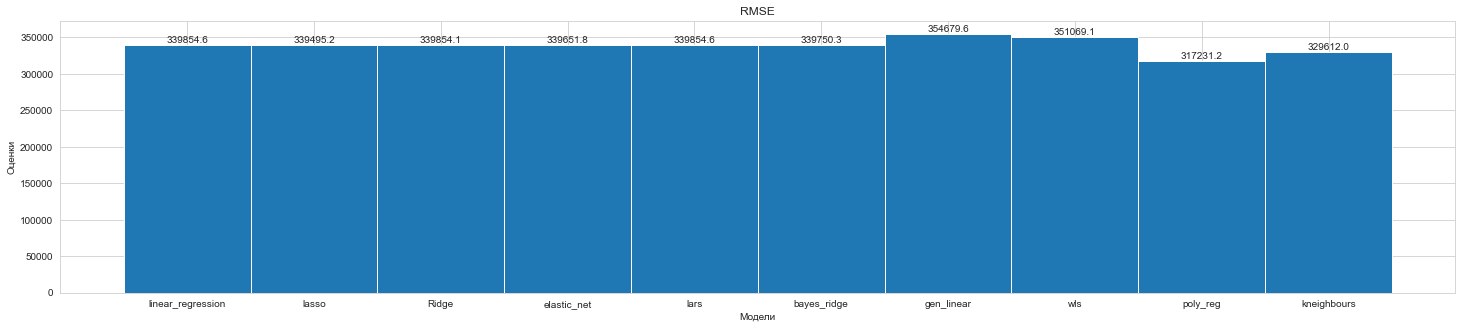

In [120]:
utilities2.build_bar_plot(labels, RMSEs, 'RMSE')

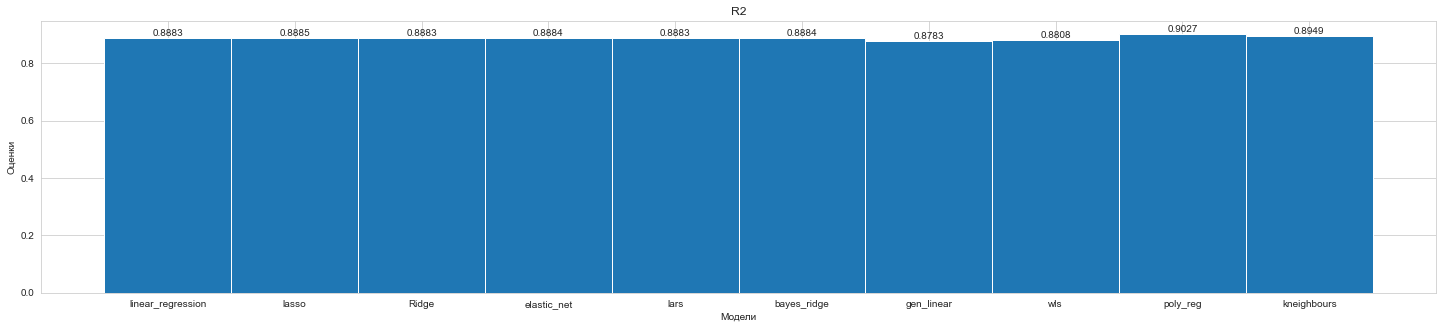

In [121]:
utilities2.build_bar_plot(labels, r2_scores, 'R2')

In [122]:
best_model = models[RMSEs.index(min(RMSEs))]
labels[RMSEs.index(min(RMSEs))]

'poly_reg'

## Спрогнозируем тестовую выборку

In [123]:
test_dataframe = pd.read_csv("train.csv", usecols = cat_attributes + num_attributes)
id_dataframe = pd.read_csv("train.csv", usecols = ["id"])
test_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Общая.площадь        808 non-null    float64
 1   Этажей.в.доме        808 non-null    int64  
 2   Совмещенный.санузел  808 non-null    int64  
 3   Год.постройки        808 non-null    int64  
 4   ВУЗ.1000             808 non-null    int64  
 5   Стоматология.1000    808 non-null    int64  
 6   Остановка.1000       808 non-null    int64  
 7   Одежда..1000         808 non-null    int64  
 8   Бар.1000             808 non-null    int64  
dtypes: float64(1), int64(8)
memory usage: 56.9 KB


In [124]:
test_dataframe[num_attributes] = test_dataframe[num_attributes].apply(pd.to_numeric, errors="coerce")
print(test_dataframe.isnull().sum())

Общая.площадь          0
Этажей.в.доме          0
Совмещенный.санузел    0
Год.постройки          0
ВУЗ.1000               0
Стоматология.1000      0
Остановка.1000         0
Одежда..1000           0
Бар.1000               0
dtype: int64


In [125]:
if labels[RMSEs.index(min(RMSEs))] == 'poly_reg':
    test_dataframe = test_dataframe[['Общая.площадь', 'Этажей.в.доме', 'Год.постройки', 'ВУЗ.1000', 'Стоматология.1000', 'Остановка.1000', 'Одежда..1000', 'Бар.1000', 'Совмещенный.санузел']]
    test_dataframe = poly_feat.transform(test_dataframe)
y_pred = best_model.predict(test_dataframe)

ValueError: X has 55 features, but LinearRegression is expecting 9 features as input.

In [ ]:
result_df = pd.DataFrame(y_pred, columns=[r_class])
result_df =  pd.concat([id_dataframe, result_df], axis=1, join='inner')

In [ ]:
result_df.to_csv("submission.csv", index=False)